In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [17]:
# Load Nvidia stock data from an Excel file
file_path = r"Downloads\NVDA_DATA.xlsx"  # Replace with your actual file path
df = pd.read_excel(file_path)

# Check first few rows of the dataset
print(df.head())




        Date  NVDA Close Price  S&P 500 Close  Bitcoin Price  NVDA Volume  \
0 2022-05-05            18.844        4146.87       36449.55    626331410   
1 2022-05-06            18.675        4123.34       36062.57    633296720   
2 2022-05-07            18.844        4123.34       36062.57    633296720   
3 2022-05-08            18.844        4123.34       34211.43    633296720   
4 2022-05-09            16.950        3991.24       30939.23    644454510   

     Vix  SOXX (Semiconductor ETF)  NVDA EPS  
0  31.20                  137.5903      0.37  
1  30.19                  136.3653      0.37  
2  30.19                  136.3653      0.37  
3  30.19                  136.3653      0.37  
4  34.75                  129.4220      0.37  


In [23]:
# Define independent variables (predictors)
X = df[['S&P 500 Close', 'Bitcoin Price', 'NVDA Volume', 'Vix' , 'SOXX (Semiconductor ETF)' , 'NVDA EPS']]

# Define dependent variable (stock price)
Y = df['NVDA Close Price']


In [25]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training data size: {X_train.shape}, Testing data size: {X_test.shape}")


Training data size: (757, 6), Testing data size: (190, 6)


In [27]:
# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Print model coefficients and intercept
print("Model Intercept:", model.intercept_)
print("Model Coefficients:", model.coef_)


Model Intercept: -58.700200679436456
Model Coefficients: [ 6.20998131e-04 -4.11291376e-04 -7.98098595e-09  1.61832706e-01
  5.94248613e-01  3.20949026e+01]


In [29]:
# Predict stock prices on the test data
Y_pred = model.predict(X_test)

# Calculate error metrics
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

# Print the evaluation results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Mean Absolute Error (MAE): 5.539678961784482
Mean Squared Error (MSE): 46.118121129972735
Root Mean Squared Error (RMSE): 6.791032405310163
R-squared (R2): 0.9734617988697688


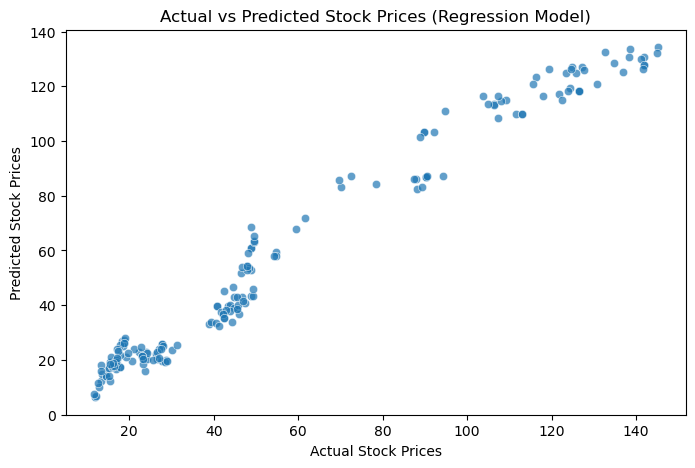

In [31]:
# Scatter plot of actual vs predicted stock prices
plt.figure(figsize=(8,5))
sns.scatterplot(x=Y_test, y=Y_pred, alpha=0.7)
plt.xlabel("Actual Stock Prices")
plt.ylabel("Predicted Stock Prices")
plt.title("Actual vs Predicted Stock Prices (Regression Model)")
plt.show()


In [33]:
# Create buy/sell signals
df_test = X_test.copy()
df_test['Actual Price'] = Y_test
df_test['Predicted Price'] = Y_pred

# Generate signals: Buy when predicted price > actual price, Sell when predicted price < actual price
df_test['Signal'] = np.where(df_test['Predicted Price'] > df_test['Actual Price'], "Buy", "Sell")

# Display results
print(df_test[['Actual Price', 'Predicted Price', 'Signal']].head(10))


     Actual Price  Predicted Price Signal
589        48.890        60.907582    Buy
932       141.950       130.831186   Sell
139        13.261        12.426072   Sell
86         18.163        26.859683    Buy
39         15.647        19.306918    Buy
778       126.570       118.319754   Sell
165        11.888         6.360136   Sell
96         17.086        20.481195    Buy
198        15.409        18.425834    Buy
250        15.909        18.826203    Buy


In [35]:
# Shift the actual prices to simulate buying and selling
df_test['Next Day Price'] = df_test['Actual Price'].shift(-1)

# Calculate theoretical returns (only when there is a Buy signal)
df_test['Return'] = np.where(df_test['Signal'] == "Buy", df_test['Next Day Price'] - df_test['Actual Price'], 0)

# Calculate total theoretical profit/loss
total_return = df_test['Return'].sum()

print(f"Total Theoretical Profit/Loss: ${total_return:.2f}")


Total Theoretical Profit/Loss: $611.57


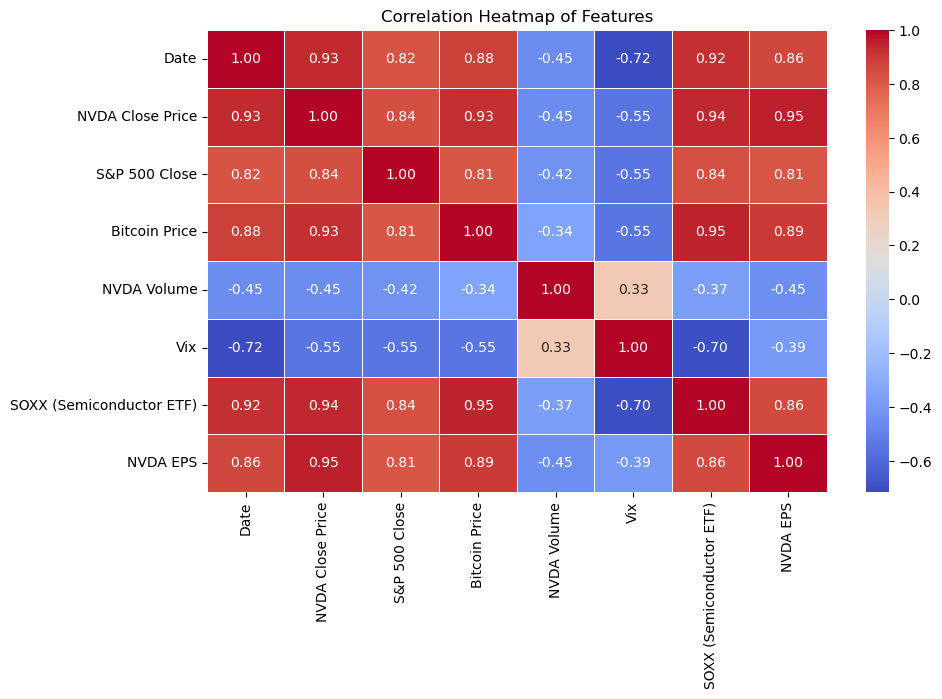

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()


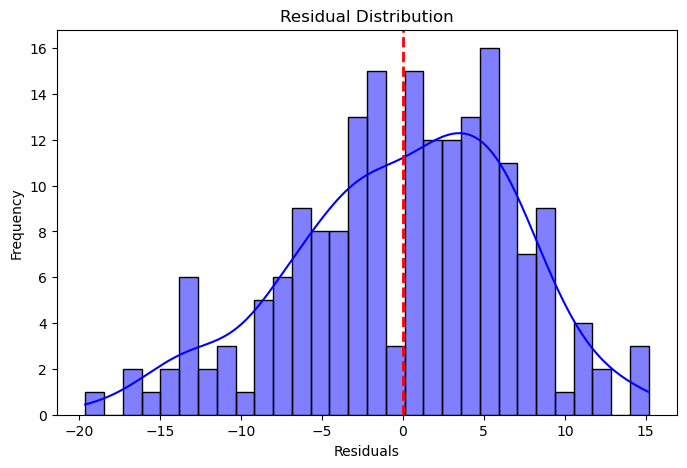

In [39]:
# Compute residuals (errors)
residuals = Y_test - Y_pred

# Plot residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


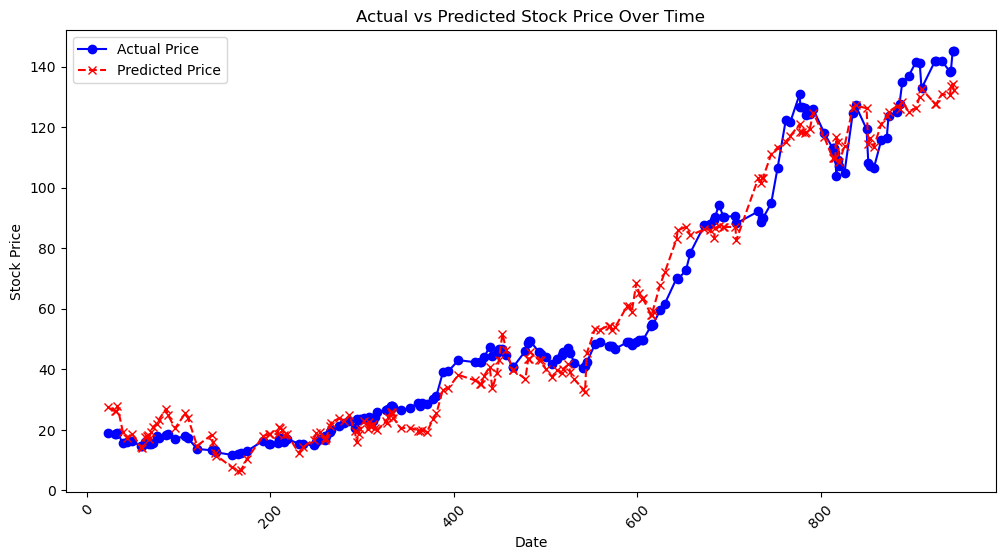

In [41]:
# Sort by date to visualize trends
df_test_sorted = df_test.sort_index()

# Plot actual vs. predicted prices
plt.figure(figsize=(12,6))
plt.plot(df_test_sorted.index, df_test_sorted['Actual Price'], label="Actual Price", linestyle="-", marker="o", color="blue")
plt.plot(df_test_sorted.index, df_test_sorted['Predicted Price'], label="Predicted Price", linestyle="--", marker="x", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Price Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()


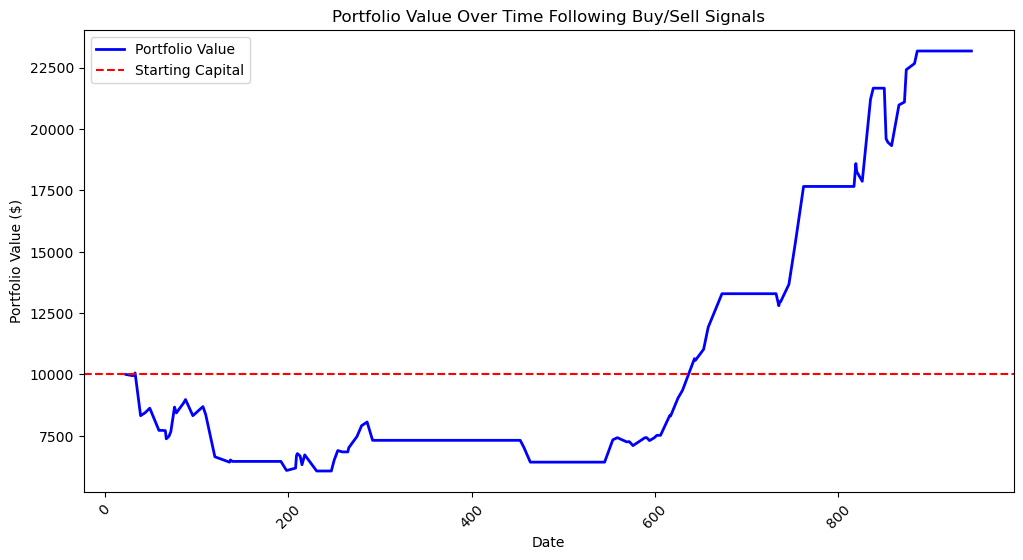

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Starting conditions
initial_capital = 10000  # Starting with $10,000
cash = initial_capital
shares = 0
portfolio_values = []  # List to store portfolio value at each date

# Iterating through each row to execute trades
for i, row in df_test_sorted.iterrows():
    price = row['Actual Price']
    signal = row['Signal']

    if signal == "Buy" and cash > 0:
        shares = cash / price  # Buy as many shares as possible
        cash = 0  # Fully invested

    elif signal == "Sell" and shares > 0:
        cash = shares * price  # Sell all shares
        shares = 0  # No holdings

    # Calculate total portfolio value
    portfolio_value = cash + (shares * price)
    portfolio_values.append(portfolio_value)

# Add portfolio values to DataFrame
df_test_sorted["Portfolio Value"] = portfolio_values

# Plot Portfolio Value Over Time
plt.figure(figsize=(12,6))
plt.plot(df_test_sorted.index, df_test_sorted['Portfolio Value'], label="Portfolio Value", color="blue", linewidth=2)
plt.axhline(y=initial_capital, color='red', linestyle="--", label="Starting Capital")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value Over Time Following Buy/Sell Signals")
plt.legend()
plt.xticks(rotation=45)
plt.show()


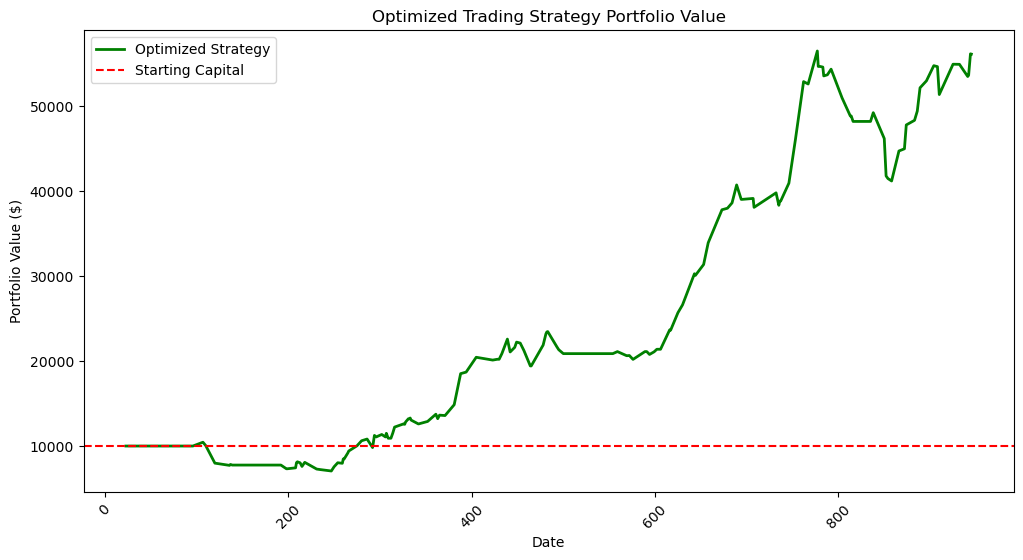

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
initial_capital = 10000  # Starting capital
cash = initial_capital
shares = 0
portfolio_values = []

# Add a 20-day Simple Moving Average (SMA) as a trend filter
df_test_sorted["SMA_20"] = df_test_sorted["Actual Price"].rolling(window=20).mean()

# Iterate through the dataset to simulate trading
for i, row in df_test_sorted.iterrows():
    price = row['Actual Price']
    signal = row['Signal']
    sma_20 = row["SMA_20"]

    # Only Buy when the stock price is above SMA (bullish trend)
    if signal == "Buy" and cash > 0 and price > sma_20:
        shares = cash / price  # Buy as many shares as possible
        cash = 0  # Fully invested

    # Only Sell when the stock price is below SMA (bearish trend)
    elif signal == "Sell" and shares > 0 and price < sma_20:
        cash = shares * price  # Sell all shares
        shares = 0  # No holdings

    # Calculate total portfolio value
    portfolio_value = cash + (shares * price)
    portfolio_values.append(portfolio_value)

# Add portfolio values to DataFrame
df_test_sorted["Optimized Portfolio Value"] = portfolio_values

# Plot the optimized portfolio value over time
plt.figure(figsize=(12,6))
plt.plot(df_test_sorted.index, df_test_sorted['Optimized Portfolio Value'], label="Optimized Strategy", color="green", linewidth=2)
plt.axhline(y=initial_capital, color='red', linestyle="--", label="Starting Capital")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Optimized Trading Strategy Portfolio Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()


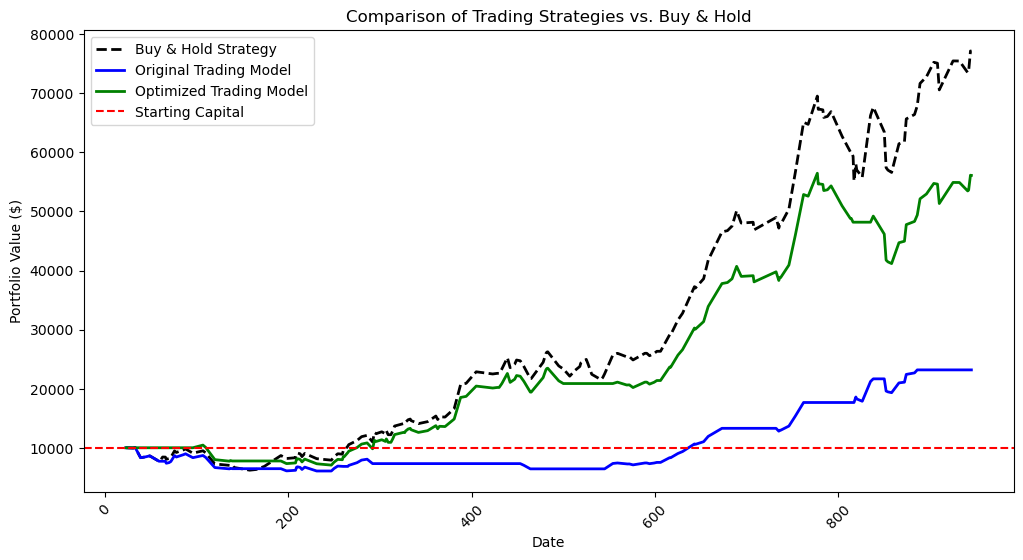

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initial investment amount
initial_capital = 10000

# Buy & Hold Strategy (Assumes investor buys on first day and holds)
first_price = df_test_sorted.iloc[0]['Actual Price']
df_test_sorted["Buy & Hold Value"] = initial_capital * (df_test_sorted["Actual Price"] / first_price)

# Plot the portfolio values for comparison
plt.figure(figsize=(12,6))

# Plot Buy & Hold Strategy
plt.plot(df_test_sorted.index, df_test_sorted['Buy & Hold Value'], label="Buy & Hold Strategy", color="black", linestyle="dashed", linewidth=2)

# Plot Original Trading Model
plt.plot(df_test_sorted.index, df_test_sorted['Portfolio Value'], label="Original Trading Model", color="blue", linewidth=2)

# Plot Optimized Trading Model
plt.plot(df_test_sorted.index, df_test_sorted['Optimized Portfolio Value'], label="Optimized Trading Model", color="green", linewidth=2)

# Add baseline
plt.axhline(y=initial_capital, color='red', linestyle="--", label="Starting Capital")

# Labels & Legend
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Comparison of Trading Strategies vs. Buy & Hold")
plt.legend()
plt.xticks(rotation=45)
plt.show()
